In [11]:
%load_ext blackcellmagic

In [12]:
%autosave 1

Autosaving every 1 seconds


In [2]:
import os
import types
import warnings
from itertools import chain

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    Callback,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from keras.datasets import cifar10, cifar100, fashion_mnist, mnist
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dense,
    Input,
    MaxPooling2D,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.utils.multi_gpu_utils import multi_gpu_model
from sklearn.metrics import confusion_matrix
from PIL import Image
import cv2
from model_ckpt_multi_gpu import ModelCkptMultiGPU
import io
from contextlib import redirect_stdout

Using TensorFlow backend.


In [3]:
np.random.seed(42)
tf.set_random_seed(42)

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ANOMALY_STR = "anomaly"
NORMAL_STR = "normal"
USE_CASE = "hazelnut"
img_path = os.path.join("imgs", USE_CASE)
if not os.path.isdir(img_path):
    os.mkdir(img_path)

ckpt_path = os.path.join("ckpts", USE_CASE)
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)
data_path = os.path.join(os.getcwd(), "data", "mvtec_anomaly_detection")

base_log_dir = os.path.join("logs", USE_CASE)

if not os.path.isdir(base_log_dir):
    os.mkdir(base_log_dir)

classes = list(
    filter(lambda d: os.path.isdir(os.path.join(data_path, d)), os.listdir(data_path))
)
classes

['bottle',
 'cable',
 'capsule',
 'carpet',
 'grid',
 'hazelnut',
 'leather',
 'metal_nut',
 'pill',
 'screw',
 'tile',
 'toothbrush',
 'transistor',
 'wood',
 'zipper']

# Preparing the data

In [5]:
def read_image_file_names(dir_path):
    """Reads images per category for given directory path.
    Returns images as a generator object in intervall[0,1] rgb-format"""
    # data = np.empty(shape=(0,1,1,3),dtype=np.int8)
    cur_shape= None
    path_to_dir = os.path.join(os.getcwd(),dir_path)
    return [os.path.join(path_to_dir,p) for p in os.listdir(dir_path)]

In [6]:
def get_path_to_data(mode):
    normal_path = os.path.join(data_path, USE_CASE, mode)
    return normal_path

In [7]:
def load_data():
    normal_path = os.path.join(data_path, USE_CASE, "train", "good")
    normal_train_data = read_image_file_names(normal_path)
    
    test_path = os.path.join(data_path,USE_CASE,"test")
    normal_test_data = read_image_file_names(os.path.join(test_path,"good"))
    anomaly_test_data = []
    for p in os.listdir(test_path):
        if p != "good":#    
            gen = read_image_file_names(os.path.join(test_path,p))
            anomaly_test_data +=  read_image_file_names(os.path.join(test_path,p))
    return normal_train_data, normal_test_data, anomaly_test_data

In [8]:
X_normal_train, X_normal_test, X_anomaly_test = load_data()
X_normal_train[:5] # contains only (absolute) file paths to the data

['C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\hazelnut\\train\\good\\000.png',
 'C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\hazelnut\\train\\good\\001.png',
 'C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\hazelnut\\train\\good\\002.png',
 'C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\hazelnut\\train\\good\\003.png',
 'C:\\Users\\danie\\coding\\cnn-auto-encoder\\data\\mvtec_anomaly_detection\\hazelnut\\train\\good\\004.png']

In [9]:
def plot_mvtec(data):
    plt.imshow(data)

In [10]:
def hide_axis(subplt, x=True, y=True):
    if x:
        subplt.get_xaxis().set_visible(False)
    if y:
        subplt.get_yaxis().set_visible(False)

In [13]:
def train_img_generator(
    file_paths, batch_size, input_only=False
):
    # yields batch_size-d arrays of images indefinetly
    # order of images is random.
    # ONLY FOR TRAIN AND EVALUATE PURPOSES SUITABLE
    while True:
        inds = (np.random.randint(0, len(file_paths), batch_size))
        imgs = np.array([])
        for i in inds:
            fp = file_paths[i]
            if os.path.isfile(fp):
                img = cv2.imread(fp)  # reads an image in the BGR format
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# BGR -> RGB
                img = cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)  
                imgs = (
                    np.concatenate((imgs, np.array([img])))
                    if imgs.size > 0
                    else np.array([img])
                )
        if not input_only:
            yield imgs / 255, imgs / 255
        else:
            yield imgs / 255

In [14]:
def img_generator(file_paths, n):
    # returns generator of n images
    if len(file_paths)< n:
        # prevent an IndexError
        n = len(file_paths)
        
    for i in range(n):
            fp = file_paths[i]
            if os.path.isfile(fp):
                img = cv2.imread(fp)  # reads an image in the BGR format
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# BGR -> RGB
                img = cv2.resize(img,dsize=(256,256),interpolation=cv2.INTER_NEAREST)  
                yield img /255

In [15]:
def plot_samples(row_one, row_two, f_plot, outfile=""):
    """Plot 8 sample images of the row_one and row_two"""
    plt.figure(figsize=(16, 4))
    # row_one
    n = 8
    for i in range(n):
        try:
            ax = plt.subplot(2, n, i+1)
            hide_axis(ax)
            nxt = next(row_one) if isinstance(row_one, types.GeneratorType) else row_one[i]
            f_plot(nxt) # row_one
        except IndexError:
            pass
        try:
            ax = plt.subplot(2, n, n+i+1)
            hide_axis(ax)
            nxt = next(row_two) if isinstance(row_two,types.GeneratorType) else row_two[i]
            f_plot(nxt) # row_two
        except IndexError:
            pass
    if outfile!="":
        plt.savefig(outfile)

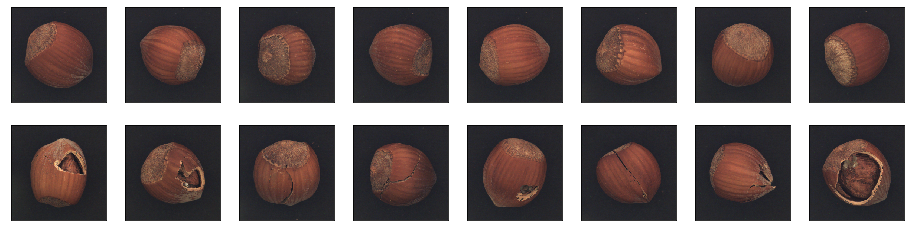

In [16]:
path = os.path.join(img_path, "{}-{}.png".format(NORMAL_STR, ANOMALY_STR))
plot_samples(
    img_generator(X_normal_test, 8), img_generator(X_anomaly_test, 8), plot_mvtec, path
)

# Extracting features with an auto encoder (ae)

In [17]:
def get_codec_from_ae(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [18]:
def build_conv_ae(filters, input_shape=(256, 256, 3)):
    if len(filters) != 9:
        raise ValueError("Four Filters must be given. Sorry.")
    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # layer between input and middle layer
    i = 0
    encode = Conv2D(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(input_img)
    i += 1
    encode = Conv2D(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(encode)
    i += 1
    encode = Conv2D(
        filters[i], (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(encode)
    i += 1
    encode = Conv2D(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(encode)
    i += 1
    encode = Conv2D(
        filters[i], (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(encode)
    i += 1
    encode = Conv2D(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(encode)
    i += 1
    encode = Conv2D(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(encode)
    i += 1
    encode = Conv2D(
        filters[i], (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(encode)
    i += 1
    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = Conv2D(
        filters[i], (8, 8), strides=(1, 1), activation="softmax", name="encoder"
    )(encode)

    i -= 1
    # layer between middle and output layer
    decode = Conv2DTranspose(filters[i], (8, 8), strides=(1, 1), activation="relu")(
        encoded
    )
    i -= 1
    decode = Conv2DTranspose(
        filters[i], (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(decode)
    i -= 1
    decode = Conv2DTranspose(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(decode)
    i -= 1
    decode = Conv2DTranspose(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(decode)
    i -= 1
    decode = Conv2DTranspose(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(decode)
    i -= 1
    decode = Conv2DTranspose(
        filters[i], (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(decode)
    i -= 1
    decode = Conv2DTranspose(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(decode)
    i -= 1
    decode = Conv2DTranspose(
        filters[i], (4, 4), strides=(2, 2), activation="relu", padding="same"
    )(decode)
    i -= 1

    decoded = Conv2D(
        input_shape[-1], (3, 3), activation="sigmoid", padding="same"
    )(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder_single = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_ae(autoencoder_single)
    # autoencoder = multi_gpu_model(autoencoder_single, 4)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adam", loss="mse")
    autoencoder_single.compile(optimizer="adam", loss="mse")
    return autoencoder, autoencoder_single, encoder, decoder

## Training the feature extractor auto encoder

preproc with keras ImageDataGenerator


In [19]:
from model_ckpt_multi_gpu import ModelCkptMultiGPU

In [20]:
def preproc_data(input_shape,batch_size):
    print("Preprocessing data to shape:", input_shape)
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            validation_split=.2,
            rotation_range=180,
            brightness_range=(0.2,1),
            horizontal_flip=True
    )
    train_generator = train_datagen.flow_from_directory(
            get_path_to_data("train"),
            target_size=input_shape[:2],
            batch_size=batch_size,
            class_mode='input',
            subset="training"
        )

    validation_generator = train_datagen.flow_from_directory(
            get_path_to_data("train"),
            target_size=input_shape[:2],
            batch_size=batch_size,
            class_mode='input',
            subset="validation"
    )
    test_generator = ImageDataGenerator(rescale=1./255.0).flow_from_directory(
            get_path_to_data("test"),
            target_size=input_shape[:2],
            batch_size=batch_size,
            class_mode='input',
            classes=["good"])

    return train_generator, validation_generator, test_generator

In [21]:
input_shape = (256, 256, 3)
batch_size = 10 

train_generator, validation_generator, test_generator = preproc_data(input_shape,batch_size)

Preprocessing data to shape: (256, 256, 3)
Found 313 images belonging to 1 classes.
Found 78 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


In [54]:
import time

In [57]:
ckpt_loc = os.path.join(ckpt_path,"cae%.0f.hdf5" % time.time())
log_dir = os.path.join(base_log_dir,str(len(os.listdir(base_log_dir))))
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)
    
#if False and os.path.isfile(ckpt_loc):
if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for %s feature extraction from directory %s..." % (USE_CASE,ckpt_loc))
    ae = load_model(ckpt_loc)

    # this needs to be compiled since the untrained, single-GPU model is saved instead of the multi-GPU model
    ae.compile(optimizer="adadelta", loss="mse") 
    encoder, decoder = get_codec_from_ae(ae)
    # ae.summary()    
else:
    print("Writing logs to %s" % log_dir)
    print("Training Autoencoder for %s feature extraction..." % USE_CASE)
    d = 164
    filters= [16,16,32,32,64,128,32,32,d]
    ae, ae_single, encoder, decoder = build_conv_ae(input_shape=input_shape,filters=filters)
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=20, verbose=1, mode="min", min_delta=(1/10**5)
    )
    mcp_save = ModelCkptMultiGPU(
        ckpt_loc, ae_single, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    tb = TensorBoard(
        log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True
    )


    f = io.StringIO()
    with redirect_stdout(f):
        ae.summary()   
    summary = f.getvalue()
    print(summary)
    
    with open(os.path.join(log_dir,"train-specs%.0f.txt" % time.time()),"w") as f:
        f.write("\n".join(("Filters: {}".format(filters),
              "Batch Size: %d"%batch_size,
              "Latent Space Dim: %d" %d,
              "Auto Encoder Network %s" % summary)))
    ae.fit_generator(
        generator=train_generator,# needs to produce data infinitely
        epochs=128,
        steps_per_epoch=len(train_generator)*batch_size,
        shuffle=True,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)*batch_size,
        callbacks=[mcp_save, earlyStopping, reduce_lr_loss, tb]
    )

Writing logs to logs\hazelnut\8
Training Autoencoder for hazelnut feature extraction...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 16)      784       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 64, 16)        4112      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 32, 32, 64)        18496     
______________________________________________________

320/320 [==============================] - 310s 969ms/step - loss: 5.5824e-04 - val_loss: 5.1292e-04

Epoch 00026: val_loss did not improve from 0.00050
Epoch 27/128
320/320 [==============================] - 271s 847ms/step - loss: 5.3593e-04 - val_loss: 5.1580e-04

Epoch 00027: val_loss did not improve from 0.00050
Epoch 28/128
320/320 [==============================] - 261s 815ms/step - loss: 5.3745e-04 - val_loss: 5.0938e-04

Epoch 00028: val_loss did not improve from 0.00050

Epoch 00028: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
Epoch 29/128
320/320 [==============================] - 260s 814ms/step - loss: 5.3344e-04 - val_loss: 4.9962e-04

Epoch 00029: val_loss did not improve from 0.00050
Epoch 30/128
320/320 [==============================] - 258s 807ms/step - loss: 5.4329e-04 - val_loss: 5.1483e-04

Epoch 00030: val_loss did not improve from 0.00050
Epoch 31/128
320/320 [==============================] - 258s 807ms/step - loss: 5.3235e-04 - val_loss:

TODO:
 - [x] fix model saving
 - [ ] fix parametrised ae building

## Evaluating the feature extractor

In [58]:
def evaluate_ae(ae, X_train_gen, X_test_gen):
    eval_train = ae.evaluate_generator(train_img_generator(X_train_gen,8), steps=len(X_train_gen))
    eval_test = ae.evaluate_generator(train_img_generator(X_test_gen,8), steps=len(X_test_gen))
    return eval_train, eval_test

In [85]:
def plot_hist(values, bins=50, relative=False, color="r"):
    t = np.linspace(values.min(), values.max(), bins)
    denominator = len(values) if relative else 1
    hist = np.histogram(values, bins)
    print(np.sum(hist[0]/denominator))
    plt.plot(t, hist[0]/denominator, color)

In [82]:
eval_train, eval_test = evaluate_ae(
    ae, X_normal_train, X_normal_test
) # estimated time: ~1 min, since one epoch of data needs to be processed
eval_train, eval_test

KeyboardInterrupt: 

In [61]:
def predict_from_generator(model, gen):
    predictions = []
    for g in gen:
        pred = model.predict(np.array([g]),batch_size=1)
        predictions.append(pred[0])
    return predictions

In [62]:
samples_normal = img_generator(X_normal_train,8)
decoded_samples_normal = predict_from_generator(ae, samples_normal)

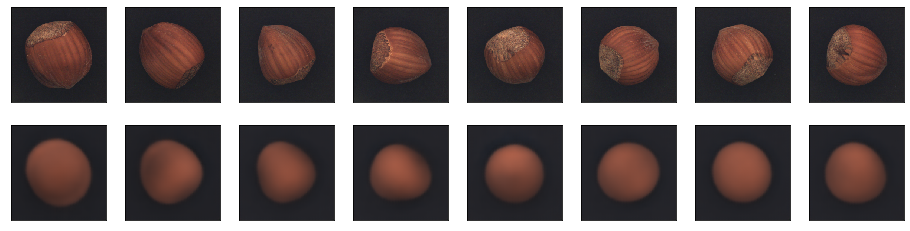

In [65]:
plot_samples(
    img_generator(X_normal_train,8),
    decoded_samples_normal,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(NORMAL_STR)),
)

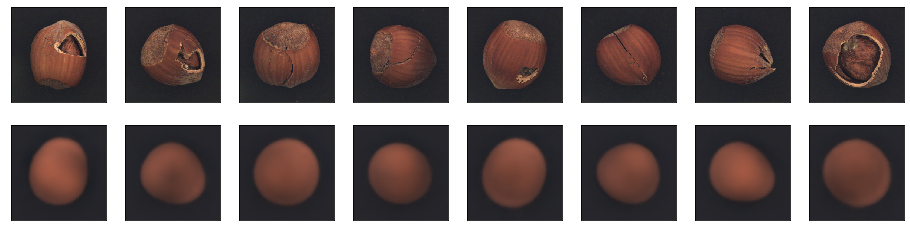

In [66]:
samples_anomaly = img_generator(X_anomaly_test,8)

decoded_samples_anomaly = predict_from_generator(ae, samples_anomaly)

plot_samples(
    img_generator(X_anomaly_test,8),
    decoded_samples_anomaly,
    plot_mvtec,
   os.path.join(img_path, "rec-{}.png".format(ANOMALY_STR)),
)

# Anomaly detection
## Loss based
### Computing the reconstruction loss for anomalies and normalities

In [67]:
def loss_per_img(img,rec_img):
    # mean squared error
    return  np.sum(np.power(rec_img - img, 2)) / (np.prod(img.shape) -1)

In [68]:
samples_normal = img_generator(
    X_normal_test, len(X_normal_test)
)  
decoded_samples_normal = predict_from_generator(ae, samples_normal)
normal_losses = np.array(
    [
        loss_per_img(i, ri)
        for i, ri in zip(
            img_generator(X_normal_test, len(X_normal_test)), decoded_samples_normal
        )
    ]
)

samples_anomaly = img_generator(
    X_anomaly_test, len(X_anomaly_test)
) 
decoded_samples_anomaly = predict_from_generator(ae, samples_anomaly)
anomaly_losses = np.array(
    [
        loss_per_img(i, ri)
        for i, ri in zip(
            img_generator(X_anomaly_test, len(X_anomaly_test)), decoded_samples_anomaly
        )
    ]
)
normal_losses.mean(), anomaly_losses.mean(), len(anomaly_losses)

(0.0008226312654739748, 0.0022119849791537114, 70)

In [69]:
len(normal_losses)

40

1.0
1.0000000000000002


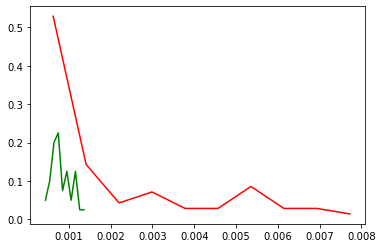

(array([2, 4, 8, 9, 3, 5, 2, 5, 1, 1], dtype=int64),
 array([0.00043929, 0.00053156, 0.00062383, 0.0007161 , 0.00080837,
        0.00090064, 0.00099291, 0.00108518, 0.00117745, 0.00126972,
        0.00136199]))

In [86]:
bins =10
# loss distribution over the normal dataset
plot_hist(normal_losses,relative=True,color="g",bins=bins)

# loss distribution over the anomaly dataset 
plot_hist(anomaly_losses,relative=True,color="r",bins=bins)
plt.show()
np.histogram(normal_losses)

### Evaluating the loss based approach

40
threshold:0.000,dn:1.000000 + ua:0.000000 = 0.500000
threshold:0.050,dn:0.950000 + ua:0.000000 = 0.475000
threshold:0.100,dn:0.900000 + ua:0.000000 = 0.450000
threshold:0.150,dn:0.850000 + ua:0.014286 = 0.432143
threshold:0.200,dn:0.800000 + ua:0.014286 = 0.407143
threshold:0.250,dn:0.750000 + ua:0.014286 = 0.382143
threshold:0.300,dn:0.700000 + ua:0.014286 = 0.357143
threshold:0.350,dn:0.650000 + ua:0.028571 = 0.339286
threshold:0.400,dn:0.600000 + ua:0.028571 = 0.314286
threshold:0.450,dn:0.550000 + ua:0.028571 = 0.289286
threshold:0.500,dn:0.500000 + ua:0.071429 = 0.285714
threshold:0.550,dn:0.450000 + ua:0.100000 = 0.275000
threshold:0.600,dn:0.400000 + ua:0.171429 = 0.285714
threshold:0.650,dn:0.350000 + ua:0.200000 = 0.275000
threshold:0.700,dn:0.300000 + ua:0.228571 = 0.264286
threshold:0.750,dn:0.250000 + ua:0.242857 = 0.246429
threshold:0.800,dn:0.200000 + ua:0.285714 = 0.242857
threshold:0.850,dn:0.150000 + ua:0.357143 = 0.253571
threshold:0.900,dn:0.100000 + ua:0.385714 =

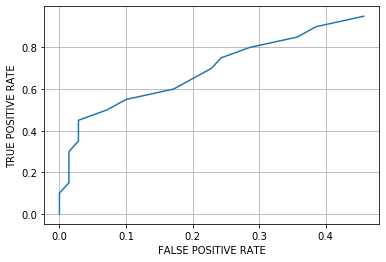

(0.8, 0.0010503840313802473)

In [87]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
FPs = FNs = []
prec = 20  # precision for getting the best threshold value
step_size = 1.0 / prec
TPs = np.arange(0, 1, step_size)
samples_anomaly = np.array(list(img_generator(X_anomaly_test, len(X_anomaly_test))))
samples_normal = np.array(list(img_generator(X_normal_test, len(X_normal_test))))

sorted_losses = np.sort(normal_losses)
print(len(sorted_losses))
for i in TPs:
    # loss value for detection of i*100 percent normal data points
    loss_boundary = sorted_losses[int(len(normal_losses) * i)]
    detected_normals = samples_normal[normal_losses >= loss_boundary]
    undetected_anomalies = samples_anomaly[anomaly_losses < loss_boundary]

    FP_rate = len(undetected_anomalies) / len(
        anomaly_losses
    )  # ratio between not detected loss values for anomalies
    FN_rate = len(detected_normals) / len(
        normal_losses
    )  # ratio between not detected loss values for anomalies

    FPs = np.append(FPs, FP_rate)  # not detected anomalies
    FNs = np.append(FNs, FN_rate)  # as anomalies detected normalities
    if (FP_rate + FN_rate) / 2 <= min(
        (FNs + FPs) / 2
    ):  # less or equal since we want the biggest TP_rate (i)
        loss_threshold = i
        best_boundary = loss_boundary

    # print every 1/10 threshold step
    if (int(i * prec)) % (prec // 20) == 0:
        print(
            "threshold:%.3f,dn:%f + ua:%f = %f"
            % (i, FN_rate, FP_rate, (FN_rate + FP_rate) / 2)
        )
    # minimum value for FN_rate + FP_rate (least relative amount of falsely detected)

plt.plot(FPs, TPs)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()
loss_threshold, best_boundary

In [88]:
detected_normals =samples_normal[normal_losses >= best_boundary]  # values on the boundary are seen as anomalies
undetected_anomalies =samples_anomaly[anomaly_losses < best_boundary]
len(detected_normals), len(undetected_anomalies)

(8, 20)

In [89]:
# plot_samples(detected_normals,undetected_anomalies,plot_mvtec, os.path.join(img_path,"wrong-{}.png".format(USE_CASE)))

### Predicting with the reconstruction loss approach

In [90]:
def is_anomaly(X,boundary):
    rec_img = ae.predict(X.reshape(1,*X.shape))
    loss =  loss_per_img(rec_img,X)
    print(loss)
    return loss > boundary

In [91]:
this_should_be_false = is_anomaly(samples_normal[5], best_boundary)
this_should_be_true = is_anomaly(samples_anomaly[5], best_boundary)
this_should_be_false, this_should_be_true

0.001239832866849171
0.0007168989260517428


(True, False)

## One Class SVM approach

In [92]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score,accuracy_score

In [93]:
encoded_normal_imgs_train = encoder.predict_generator(
    train_img_generator(X_normal_train, 4), steps=len(X_normal_train)
)  # used later for One Class Classification
encoded_normal_imgs_test = encoder.predict_generator(
    train_img_generator(X_normal_test, 4), steps=len(X_normal_test)
)
encoded_anomaly_imgs_test = encoder.predict_generator(
    train_img_generator(X_anomaly_test, 4), steps=len(X_anomaly_test)
)

In [94]:
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
            -1, np.prod(encoded_normal_imgs_train.shape[1:])
        )
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
            -1, np.prod(encoded_normal_imgs_test.shape[1:])
        )
encoded_anomaly_imgs_test = encoded_anomaly_imgs_test.reshape(-1, np.prod(encoded_anomaly_imgs_test.shape[1:]))
best_metrics =0,0,0
for i in np.arange(0.1, 1, 0.1):
    clf = svm.OneClassSVM(gamma="auto", nu=i)
    clf.fit(encoded_normal_imgs_train)
    
    score_normal = clf.predict(encoded_normal_imgs_test)
    bins = 2
    # hist_normal = np.histogram(score_normal, bins)
    # t = np.linspace(score_normal.min(), score_normal.max(), bins)
    # plt.bar(t, hist_normal[0], width=0.5, color="g")
    # plt.show()

    score_anomaly = clf.predict(encoded_anomaly_imgs_test)

    # hist_anomaly = np.histogram(score_anomaly, bins)
    # t = np.linspace(score_anomaly.min(), score_anomaly.max(), bins)
    # plt.bar(t, hist_anomaly[0], width=0.5, color="r")
    # plt.show()


    TP = len(score_normal[score_normal == 1])
    FN = len(score_normal[score_normal == -1])

    TN = len(score_anomaly[score_anomaly == -1])
    FP = len(score_anomaly[score_anomaly == 1])
    accuracy = (TP + TN) / (len(score_normal) + len(score_anomaly))
    precision = TP / (TP + FN) if TP*FN != 0 else 0
    recall = TP / (TP + FP) if TP*FP != 0 else 0
    if (accuracy,precision,recall) > best_metrics:
        best_nu = i
        best_metrics = accuracy,precision,recall
        oc_svm = clf
    print("%.2f" % i, accuracy, precision, recall)
best_nu,best_metrics

0.10 0.41818181818181815 0.7625 0.3588235294117647
0.20 0.41363636363636364 0.75 0.35502958579881655
0.30 0.4090909090909091 0.7875 0.35795454545454547
0.40 0.425 0.73125 0.3577981651376147
0.50 0.4863636363636364 0.675 0.3829787234042553
0.60 0.5454545454545454 0.65 0.41935483870967744
0.70 0.5886363636363636 0.26875 0.40186915887850466
0.80 0.575 0.2 0.3516483516483517
0.90 0.5886363636363636 0 0


(0.7000000000000001, (0.5886363636363636, 0.26875, 0.40186915887850466))

In [95]:
def is_anomaly_svm(X,oc_svm):
    X = X.reshape((1,X.shape[0]))
    prediction = oc_svm.predict(X)[0]
    return prediction == -1

In [96]:
this_should_be_false_svm = is_anomaly_svm(encoded_normal_imgs_train[2], oc_svm)
this_should_be_true_svm = is_anomaly_svm(encoded_anomaly_imgs_test[-1], oc_svm)
this_should_be_false_svm, this_should_be_true_svm

(True, True)

# TODO: Encoded feature analysis with our friend CF Gauss

In [97]:
flat_shape = np.prod(encoded_normal_imgs_train.shape[1:], dtype=np.int64)
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
    len(encoded_normal_imgs_train), flat_shape
)
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
    len(encoded_normal_imgs_test), flat_shape
)

In [98]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [99]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [100]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [101]:
def p(X,my,sigma2):
    return np.array([np.sum([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [104]:
X= encoded_normal_imgs_test
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
len(my), len(my)

(164, 164)

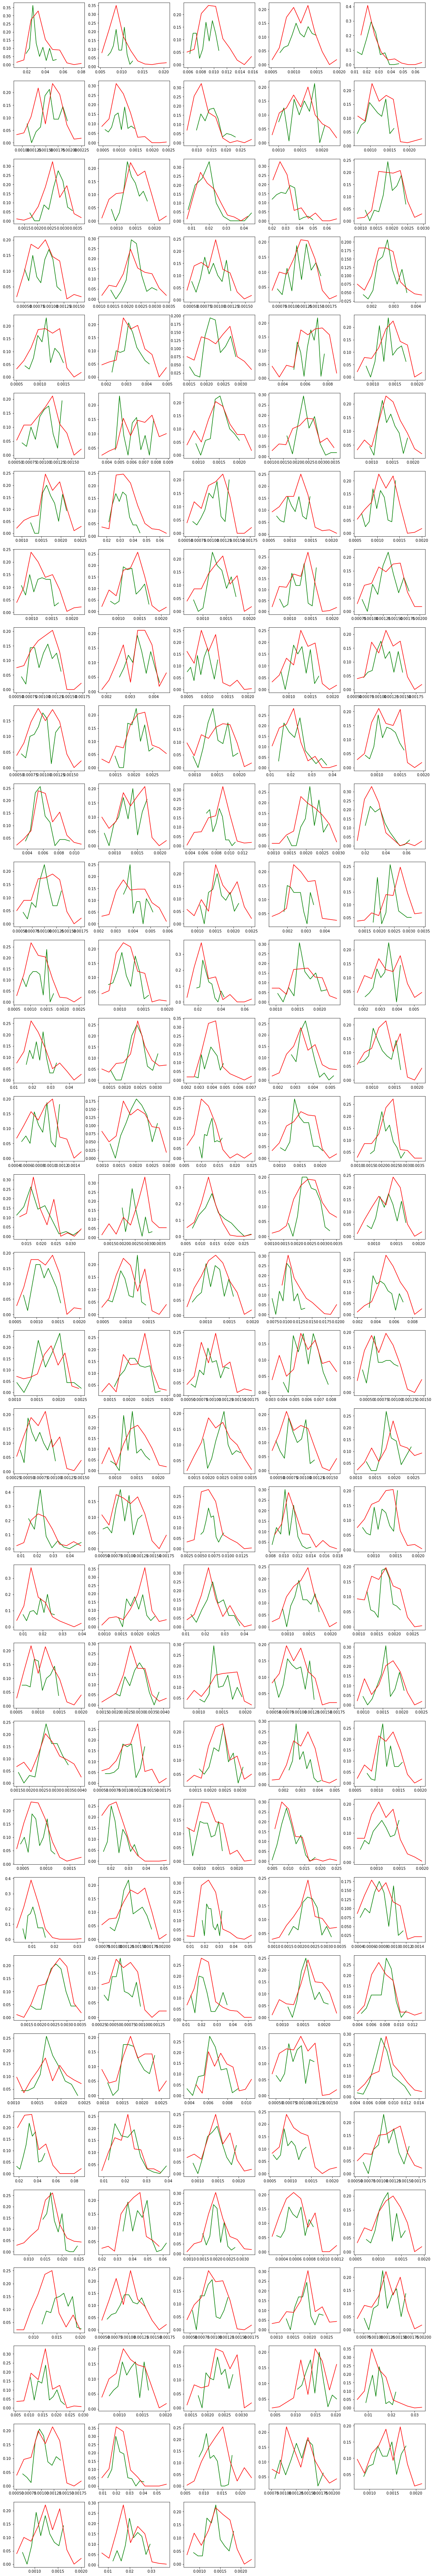

In [103]:
X= encoded_normal_imgs_test
X_a = encoded_anomaly_imgs_test

m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
cols = 5 # entspricht 20 pixel
plt.figure(figsize=( 20,(len(my)//cols) * 4))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 10
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot((len(my)//cols)+1, cols, i + 1)
    
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]),color="g")
             
    hist = np.histogram(X_a[:, i], bins=bins)
    r = np.linspace(start=min(X_a[:, i]), stop=max(X_a[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X_a[:,i]),color="r")        